<h2> 6. Bayes Classification </h2>

This notebook has the code for the charts in Chapter 6


### Install BigQuery module

You don't need this on AI Platform, but you need this on plain-old JupyterLab

In [11]:
#!pip install google-cloud-bigquery
!pip install google-cloud-bigquery==1.24.0
!pip install google-cloud-bigquery-storage

     |████████████████████████████████| 165 kB 3.4 MB/s 
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 1.0.0
    Uninstalling google-resumable-media-1.0.0:
      Successfully uninstalled google-resumable-media-1.0.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

google-cloud-storage 1.31.0 requires google-resumable-media<2.0dev,>=1.0.0, but you'll have google-resumable-media 0.5.1 which is incompatible.


In [1]:
#!pip uninstall google-cloud-bigquery google-cloud-bigquery-storage pandas pandas-gbq pyarrow -y

!pip install google-cloud-bigquery==1.20.0 google-cloud-bigquery-storage==0.7.0 pandas==0.25.1 pandas-gbq==0.11.0 pyarrow==0.14.1

In [12]:
!pip freeze

alabaster==0.7.10
alembic==1.4.2
anaconda-client==1.6.14
anaconda-navigator==1.8.7
anaconda-project==0.8.2
asn1crypto==0.24.0
astroid==1.6.3
astropy==3.0.2
async-generator==1.10
attrs==18.1.0
Babel==2.5.3
backcall==0.2.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
blinker==1.4
bokeh==0.12.16
boto==2.48.0
Bottleneck==1.2.1
brotlipy==0.7.0
cachetools==4.1.1
certifi==2020.6.20
certipy==0.1.3
cffi @ file:///tmp/build/80754af9/cffi_1598370789085/work
chardet==3.0.4
click==6.7
cloudpickle==0.5.3
clyent==1.2.2
colorama==0.3.9
conda==4.5.4
conda-build==3.10.5
conda-verify==2.0.0
contextlib2==0.5.5
cryptography @ file:///tmp/build/80754af9/cryptography_1598892041992/work
cycler==0.10.0
Cython==0.28.2
cytoolz==0.9.0.1
dask==0.17.5
datashape==0.5.4
decorator==4.4.2
distributed==1.21.8
docutils==0.14
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.4
findspark==1.3.0
Flask==1.0.2
Flask-Cors==3.0.4
gevent

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Setup

In [3]:
import os
PROJECT = 'hpc-dev-285311' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'gcp-de-1' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

os.environ['BUCKET'] = BUCKET

<h3> Exploration using BigQuery </h3>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import google.cloud.bigquery as bigquery

bq = bigquery.Client()

In [5]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.query(sql).to_dataframe()

/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


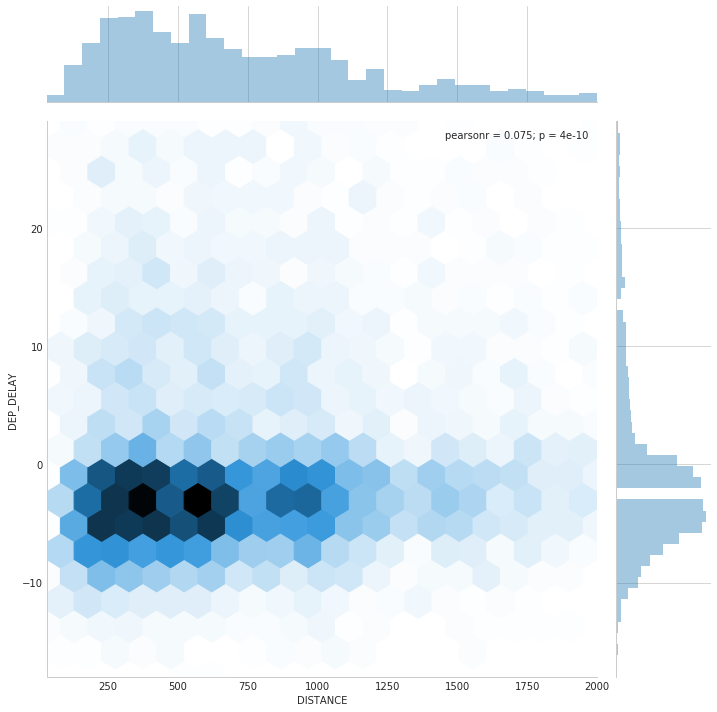

In [6]:
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Set up views in Spark SQL </h3>

Start a Spark Session if necessary and get a handle to it.

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
print(spark)

Set up the schema to read in the CSV files on GCS

In [8]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])
print(schema)

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

Create a table definition (this is done lazily; the files won't be read until we issue a query):

In [13]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

Example query over the view (this will take a while; it's Spark SQL, not BigQuery):

In [14]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000')
results.show()

+--------+
|count(1)|
+--------+
|  446142|
+--------+



In [15]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000')
results.show()

+--------+
|count(1)|
+--------+
|  446142|
+--------+



<h2> Restrict to train days </h2>

Let's create a CSV file of the training days

In [16]:
sql = """
SELECT *
FROM `flights.trainday`
"""
df = bq.query(sql).to_dataframe()
df.to_csv('trainday.csv', index=False)

In [17]:
!head -3 trainday.csv

FL_DATE,is_train_day
2015-01-01,True
2015-01-04,True


In [18]:
%%bash
gsutil cp trainday.csv gs://${BUCKET}/flights/trainday.csv

Copying file://trainday.csv [Content-Type=text/csv]...
/ [1 files][  8.7 KiB/  8.7 KiB]                                                
Operation completed over 1 objects/8.7 KiB.                                      


Create dataframe of traindays, but this time because the file has a header, and is a small file, we can have Spark infer the schema

In [19]:
traindays = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

traindays.createOrReplaceTempView('traindays')

In [20]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 7, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 8, 0, 0), is_train_day=True)]

In [21]:
statement = """
SELECT
  f.FL_DATE AS date,
  distance,
  dep_delay
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day AND
  f.dep_delay IS NOT NULL
ORDER BY
  f.dep_delay DESC
"""
flights = spark.sql(statement)

<h3> Hexbin plot </h3>

Create a hexbin plot using Spark (repeat of what we did in BigQuery, except that we are now restricting to train days only).

In [22]:
df = flights[(flights['distance'] < 2000) & (flights['dep_delay'] > -20) & (flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+------------------+--------------------+
|summary|      date|          distance|           dep_delay|
+-------+----------+------------------+--------------------+
|  count|    234358|            234358|              234358|
|   mean|      null| 730.6918901851014|-0.08475494755886294|
| stddev|      null|455.66260751180835|   8.319044875846881|
|    min|2016-06-01|              31.0|               -19.0|
|    max|2016-06-30|            1999.0|                29.0|
+-------+----------+------------------+--------------------+



Sample the dataframe so that it fits into memory (not a problem in development, but will be on full dataset); then plot it.

/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


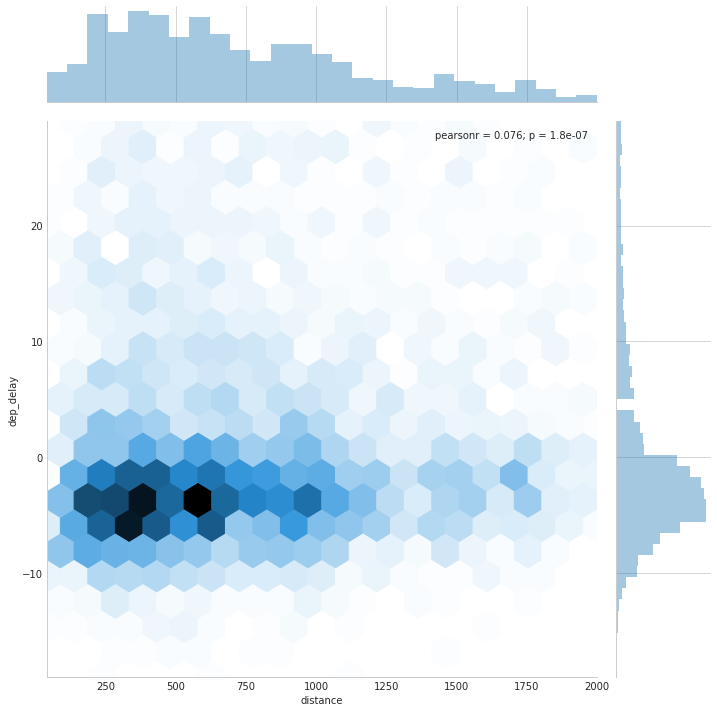

In [23]:
pdf = df.sample(False, 0.02, 20).toPandas()  # to 100,000 rows approx on complete dataset
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Quantization </h3>

Now find the quantiles

In [24]:
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
distthresh

[31.0, 239.0, 373.0, 484.0, 594.0, 714.0, 872.0, 1046.0, 1448.0, 2248.0]

In [25]:
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.05)
delaythresh

[-54.0, -8.0, -5.0, -4.0, -2.0, -1.0, 1.0, 7.0, 25.0, 76.0]

In [26]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay >= 3 AND dep_delay < 8 AND distance >= 447 AND distance < 557')
results.show()

+--------+
|count(1)|
+--------+
|    2712|
+--------+



<h2> Repeat, but on full dataset </h2>

You can launch the above processing on the full dataset from within JupyterLab if you want the statistics and graphs updated. I didn't, though, because this is not what I would have really done. Instead, 
I would have created a standalone Python script and submitted it to the cluster -- there is no need to put JupyterLab in the middle of a production process. We'll submit a standalone Pig program to the cluster in the next section.

Steps:
<ol>
<li> Change the input variable to process all-flights-* </li>
<li> Increase cluster size (bash increase_cluster.sh from CloudShell) </li>
<li> Clear all cells from this notebook </li>
<li> Run all cells </li>
<li> Decrease cluster size (bash decrease_cluster.sh from CloudShell) </li>
</ol>


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.